<a href="https://colab.research.google.com/github/trikialaa/Flashing_recognition/blob/master/Flashing_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading the libraries

In [0]:
import cv2
import imutils
import numpy as np
import os
from google.colab.patches import cv2_imshow

importing the two images and convering them to greyscale

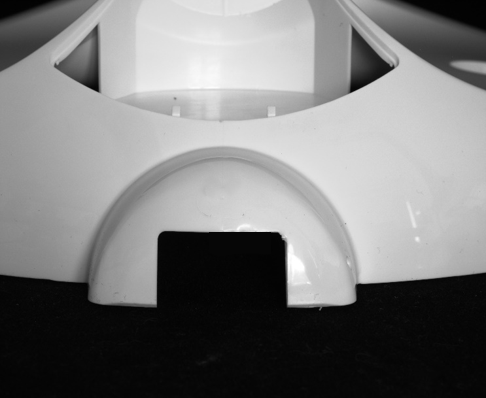

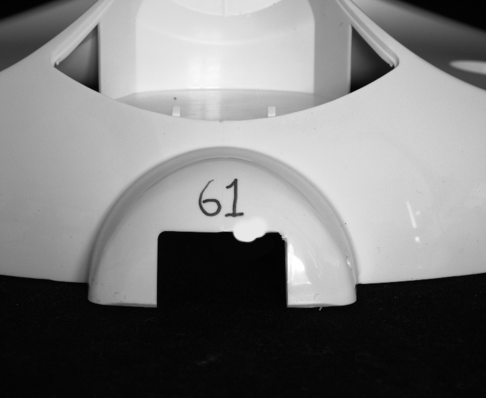

In [0]:
img1 = cv2.imread('sample_without_flashing.png')
img2 = cv2.imread('sample_with_flashing.png')
img1 = cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
cv2_imshow(img1)
cv2_imshow(img2)

creating a mask on the first picture

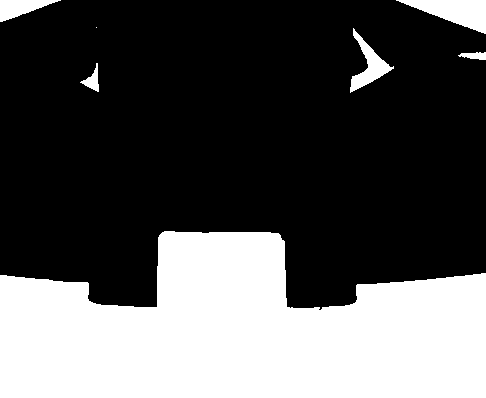

In [0]:
mask = img1.copy()
mask = cv2.threshold(mask, 50, 255, cv2.THRESH_BINARY_INV)[1]
cv2_imshow(mask)

removing the upper part of the mask

In [0]:
(h, w) = mask.shape
print(h, w)

398 486


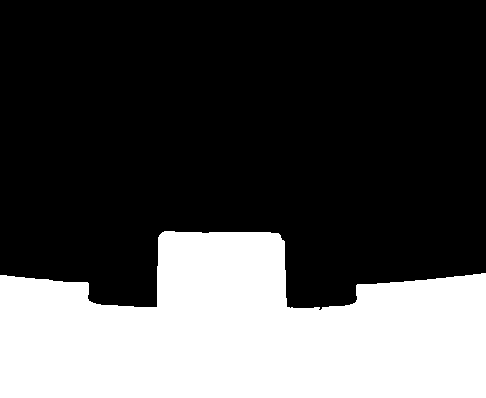

In [0]:
for i in range(w):
  for j in range(int(h/2)):
    mask[j][i]=0

cv2_imshow(mask)

applying the mask to the second picture

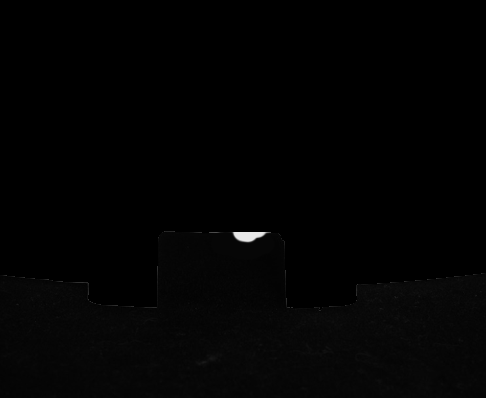

In [0]:
pic_masked = cv2.bitwise_and(img2, img2, mask=mask)
cv2_imshow(pic_masked)

applying binarization

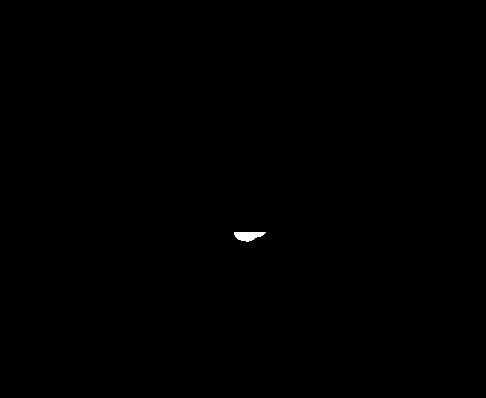

In [0]:
pic_masked = cv2.threshold(pic_masked, 180, 255, cv2.THRESH_BINARY)[1]
cv2_imshow(pic_masked)

calculating surface area and converting it to mm²

In [0]:
PIC_RESOLUTION = 0.045

im2,contours,hierarchy = cv2.findContours(pic_masked, 1, 2)
cnt = contours[0]

surface_in_pixels = area = cv2.contourArea(cnt)

surface_in_mm2 = surface_in_pixels * PIC_RESOLUTION
print(str(surface_in_mm2)+' mm²')

8.2125 mm²


locating the position of the numbers

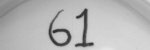

In [0]:
img_nbr = img2[170:220,150:300]
cv2_imshow(img_nbr)

applying threshold

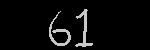

In [0]:
mask_nbr = img_nbr.copy()
mask_nbr = cv2.threshold(mask_nbr, 120, 200, cv2.THRESH_BINARY_INV)[1]
cv2_imshow(mask_nbr)

applying segmentation

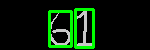

In [0]:
cnts = cv2.findContours(mask_nbr, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
digitCnts = []

mask_nbr_seg = mask_nbr.copy()
mask_nbr_seg = cv2.cvtColor(mask_nbr_seg, cv2.COLOR_GRAY2BGR)

i=0

for c in cnts:
  (cx, cy, cw, ch) = cv2.boundingRect(c)
  digitCnts.append(c)
  i+=1
  cv2.rectangle(mask_nbr_seg, (cx,cy), (cx+cw,cy+ch), (0,255,0), 2)

cv2_imshow(mask_nbr_seg)

classification model

In [0]:
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Reshaping the array to 4-dims so that it can work with the Keras API
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
input_shape = (28, 28, 1)
# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255
x_test /= 255

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
# Creating a Sequential Model and adding the layers
model = Sequential()
model.add(Conv2D(28, kernel_size=(3,3), input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dense(128, activation=tf.nn.relu))
model.add(Dropout(0.2))
model.add(Dense(10,activation=tf.nn.softmax))

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.fit(x=x_train,y=y_train, epochs=10)



Epoch 1/10
60000/60000 [==============================] - 41s 683us/step - loss: 0.2120 - acc: 0.9361
Epoch 2/10
60000/60000 [==============================] - 41s 676us/step - loss: 0.0887 - acc: 0.9730
Epoch 3/10
60000/60000 [==============================] - 39s 655us/step - loss: 0.0605 - acc: 0.9811
Epoch 4/10
60000/60000 [==============================] - 40s 662us/step - loss: 0.0458 - acc: 0.9850
Epoch 5/10
60000/60000 [==============================] - 40s 659us/step - loss: 0.0376 - acc: 0.9874
Epoch 6/10
60000/60000 [==============================] - 39s 657us/step - loss: 0.0299 - acc: 0.9899
Epoch 7/10
60000/60000 [==============================] - 40s 669us/step - loss: 0.0265 - acc: 0.9911
Epoch 8/10
60000/60000 [==============================] - 40s 659us/step - loss: 0.0227 - acc: 0.9921
Epoch 9/10
60000/60000 [==============================] - 40s 660us/step - loss: 0.0206 - acc: 0.9933
Epoch 10/10
60000/60000 [==============================] - 39s 655us/step - loss: 

In [0]:
full_number=0
for c in cnts:
  (cx, cy, cw, ch) = cv2.boundingRect(c)
  im_digit = mask_nbr[cy:cy+ch,cx:cx+cw]
  im_digit = cv2.resize(im_digit,(20,20))
  im_digit = cv2.copyMakeBorder(
                 im_digit, 
                 4, 
                 4, 
                 4, 
                 4, 
                 cv2.BORDER_CONSTANT, 
                 value=0
              )
  im_digit = cv2.erode(im_digit, (7,7), iterations=1)
  cv2_imshow(im_digit)
  im_digit = im_digit / 255
  im_digit_transformed = np.zeros((28,28,1))
  for i in range(28):
    for j in range(28):
      im_digit_transformed[i][j][0]=im_digit[i][j]
  predicted = model.predict(im_digit_transformed.reshape(1, 28, 28, 1)).argmax()
  print(str(predicted)+'\n')
  full_number*=10
  full_number+= predicted

print('\n\nThe number is: '+str(full_number))

3



1



The number is: 31
